In [17]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import numpy as np
import PIL
import keras

In [18]:
#设置显卡使用情况和限制显存使用情况
# 指定第一块GPU可用 
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #Titan XP
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)


In [19]:
# VGG16 : 太容易过拟合 先不用
# top_model = Sequential()
# top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
# top_model.add(Dense(256,activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(2,activation='softmax'))
# model = Sequential()
# vgg16_model = VGG16(weights='imagenet',include_top=False, input_shape=(256,256,3))
# model.add(vgg16_model)
# model.add(top_model)

#3层卷积
imgSize = 256  #图片尺寸
imgChan = 3    #3通道
kernelInit = 'uniform'  #卷积核初始化方式
nHiddenUnits = 50
maxpoolSize = (2,2)
nFilters = 130 #130 before 
kernelSize = (2,2)
inputStrides = 1
costFunction = 'categorical_crossentropy' #代价函数:不同于损失函数，代价函数在整个训练集上计算
early_stop_delta = 0.01 # 0.01 change or above is considered improvement
early_stop_patience = 10 

model=Sequential()

model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 input_shape=(imgSize,imgSize,3),kernel_initializer= kernelInit))
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=maxpoolSize))


model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 kernel_initializer= kernelInit))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=maxpoolSize))


model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 kernel_initializer= kernelInit))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=maxpoolSize))

model.add(Flatten())
model.add(Dense(nHiddenUnits))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=early_stop_delta, patience=early_stop_patience, verbose=2, mode='auto')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 255, 255, 130)     1690      
_________________________________________________________________
activation_6 (Activation)    (None, 255, 255, 130)     0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 130)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 130)     67730     
_________________________________________________________________
activation_7 (Activation)    (None, 126, 126, 130)     0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 130)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 130)       67730     
__________

In [20]:
#测试 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range = 40,     # 随机旋转度数
    width_shift_range = 0.2, # 随机水平平移
    height_shift_range = 0.2,# 随机竖直平移
    rescale = 1/255,         # 数据归一化
    shear_range = 20,       # 随机错切变换
    zoom_range = 0.2,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    fill_mode = 'nearest',   # 填充方式
)
test_datagen = ImageDataGenerator(
    rescale = 1/255,         # 数据归一化
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255,)

In [21]:
batch_size = 5
# 生成训练数据
train_generator = train_datagen.flow_from_directory(
    '../../data/imgProcessed/training',
    target_size=(imgSize,imgSize),
    batch_size=batch_size,
    class_mode='binary',
    )

# 测试数据
test_generator = test_datagen.flow_from_directory(
    '../../data/imgProcessed/test',
    target_size=(imgSize,imgSize),
    batch_size=batch_size,
    class_mode='binary',
    )

#验证集
validation_generator = validation_datagen.flow_from_directory(
    '../../data/imgProcessed/validation',
    target_size=(imgSize,imgSize),
    batch_size=batch_size,
    class_mode='binary',
    )

Found 244 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [22]:
train_generator.class_indices

{'m': 0, 's': 1}

In [23]:
#model.compile(optimizer=SGD(lr=1e-4,momentum=0.9),loss=costFunction,metrics=['categorical_accuracy'])
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),loss="binary_crossentropy",metrics=['binary_accuracy'])

In [24]:
from PIL import Image
history = model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=20,validation_data=validation_generator,validation_steps=len(validation_generator))

Epoch 1/20
49/49 [==============================] - 9s 193ms/step - loss: 0.6866 - binary_accuracy: 0.4888 - val_loss: 0.5932 - val_binary_accuracy: 0.7917
Epoch 2/20
49/49 [==============================] - 9s 191ms/step - loss: 0.6536 - binary_accuracy: 0.5694 - val_loss: 0.7106 - val_binary_accuracy: 0.5000
Epoch 3/20
49/49 [==============================] - 10s 198ms/step - loss: 0.6427 - binary_accuracy: 0.6602 - val_loss: 0.5233 - val_binary_accuracy: 0.7083
Epoch 4/20
49/49 [==============================] - 10s 199ms/step - loss: 0.6069 - binary_accuracy: 0.6878 - val_loss: 0.3484 - val_binary_accuracy: 0.8542
Epoch 5/20
49/49 [==============================] - 9s 187ms/step - loss: 0.4245 - binary_accuracy: 0.8153 - val_loss: 0.2793 - val_binary_accuracy: 0.8542
Epoch 6/20
49/49 [==============================] - 9s 190ms/step - loss: 0.3729 - binary_accuracy: 0.8367 - val_loss: 0.2862 - val_binary_accuracy: 0.8542
Epoch 7/20
49/49 [==============================] - 9s 188ms/s

In [25]:
model.save("../../model/Conv3_256_2by2_Adam_epoch20.h5")

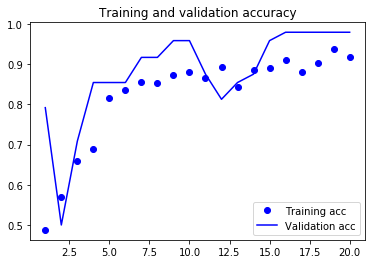

TypeError: imshow() missing 1 required positional argument: 'X'

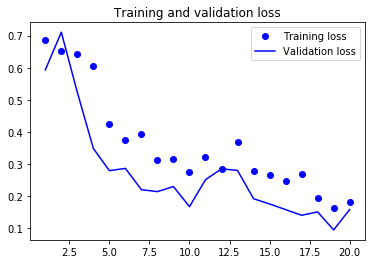

In [26]:
#画出结果
import matplotlib.pyplot as plt

#查看变量，发现history.history中就只有这四个值，分别是准确度，验证集准确度，损失，验证集损失
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#画两个图，分别是正确率和验证损失率
#正确率
plt.figure(1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('acc.png')
plt.show()
#损失
plt.figure(2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.imshow()
